In [3]:
import torch
import pandas as pd
import seaborn as sns


In [4]:
import warnings
warnings.filterwarnings('ignore')

# Import Data

In [9]:
import dagshub
import pandas as pd

df_train = pd.read_csv(r'C:\Users\DhalS\OneDrive - Kantar\Desktop\Omdena\IREX-El-Salvador-Sentiment\experiment\task-01-data-collection\manual_labels\train_df_1000_manual.csv')

df_test = pd.read_csv(r'C:\Users\DhalS\OneDrive - Kantar\Desktop\Omdena\IREX-El-Salvador-Sentiment\experiment\task-01-data-collection\manual_labels\test_df_500_manual.csv')

total_df = pd.concat([df_train, df_test], axis=0)
total_df.shape

(1500, 36)

In [10]:

# Assuming df_train is already loaded
# Renaming the column
df_train.rename(columns={'manual labeling': 'manual_labeling'}, inplace=True)
df_test.rename(columns={'manual labeling': 'manual_labeling'}, inplace=True)
total_df.rename(columns={'manual labeling': 'manual_labeling'}, inplace=True)


In [11]:
label_mapping = {-1: 0, 0: 1, 1: 2}

df_train['label'] = df_train['manual_labeling'].map(label_mapping)
df_test['label'] = df_test['manual_labeling'].map(label_mapping)
total_df['label'] = total_df['manual_labeling'].map(label_mapping)

# Preprocess for BERT Train


In [12]:
import pandas as pd
import numpy as np
import os
import random
from pathlib import Path
import json

In [13]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset


from transformers import BertForSequenceClassification

In [29]:
class Config():
    seed_val = 17
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 3
    batch_size = 6
    seq_length = 512
    lr = 2e-5
    eps = 1e-8
    pretrained_model = 'dccuchile/bert-base-spanish-wwm-uncased'  # Spanish BERT model
    random_state=42
    add_special_tokens=True
    return_attention_mask=True
    pad_to_max_length=True
    do_lower_case=False
    return_tensors='pt'

config = Config()


class Config():
    seed_val = 17
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 3
    batch_size = 6  # Reduced batch size
    seq_length = 512
    lr = 2e-5
    eps = 1e-8
    pretrained_model = 'dccuchile/bert-base-spanish-wwm-uncased'  # Spanish BERT model
    random_state = 42
    add_special_tokens = True
    return_attention_mask = True
    pad_to_max_length = True
    do_lower_case = False
    return_tensors = 'pt'
    gradient_accumulation_steps = 2  # Accumulate gradients over 2 steps
    early_stopping_patience = 2  # Stop training if validation loss doesn't improve for 2 epochs

config = Config()


In [30]:
# params will be saved after training
params = {"seed_val": config.seed_val,
    "device":str(config.device),
    "epochs":config.epochs,
    "batch_size":config.batch_size,
    "seq_length":config.seq_length,
    "lr":config.lr,
    "eps":config.eps,
    "pretrained_model": config.pretrained_model,
    "random_state":config.random_state,
    "add_special_tokens":config.add_special_tokens,
    "return_attention_mask":config.return_attention_mask,
    "pad_to_max_length":config.pad_to_max_length,
    "do_lower_case":config.do_lower_case,
    "return_tensors":config.return_tensors,
         }

In [31]:
# set random seed and device
import random
import numpy as np


device = config.device

random.seed(config.seed_val)
np.random.seed(config.seed_val)
torch.manual_seed(config.seed_val)
torch.cuda.manual_seed_all(config.seed_val)

In [32]:
df_train.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'comment_url', 'comment_createdAt',
       'comment_id', 'comment_viewCount', 'comment_lang',
       'comment_author_createdAt', 'comment_location', 'comment_text',
       'isComment_self__decalred__location__El_Salvador',
       'comment_processed_text', 'post_url', 'post_actor_createdAt', 'post_id',
       'post_isReply', 'post_inReplyToId', 'post_isRetweet', 'post_isQuote',
       'post_viewCount', 'post_retweetCount', 'post_likeCount',
       'post_replyCount', 'post_lang', 'actor_location', 'post_name',
       'post_description', 'post_followers', 'post_verified', 'post_text',
       'isActor_self__decalred__location__El_Salvador', 'post_processed_text',
       'actor_affiliation', 'llama3_output', 'llama3_reason',
       'manual_labeling', 'label'],
      dtype='object')

#Train and Validation Split

In [33]:
#split train test
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df_train,
                                    test_size=0.30,
                                    random_state=config.random_state,
                            stratify=df_train.label.values)

In [20]:
train_df.head()


,Unnamed: 0.1,Unnamed: 0,comment_url,comment_createdAt,comment_id,comment_viewCount,comment_lang,comment_author_createdAt,comment_location,comment_text,...,post_followers,post_verified,post_text,isActor_self__decalred__location__El_Salvador,post_processed_text,actor_affiliation,llama3_output,llama3_reason,manual_labeling,label
696,488,3072,https://x.com/JAAguilarp/status/12802133915466...,1.594062e+09,1.280210e+18,NaN,es,19/06/2010,valencia,@ChristianDiffer @nayibbukele No se porque dud...,...,15986.0,False,ULTIMA HORA\r\n\r\nEl presidente del partido A...,True,ultima hora el presidente del partido arena di...,Media,1.0,The tweet expresses trust and confidence in th...,0,1
238,146,671,https://x.com/sirabordo/status/177383783438790...,1.711751e+09,1.773840e+18,5.0,es,14/09/2012,Bogotá,@nayibbukele @andresmelocou Primer paso: segur...,...,6211026.0,True,“Amnistía Internacional acepta que la estrateg...,True,amnistía internacional acepta que la estrategi...,Government,1.0,The tweet expresses admiration and praise for ...,0,1
314,100,435,https://x.com/ricardorivassv/status/1773093902...,1.711574e+09,1.773090e+18,2753.0,es,02/10/2012,NaN,@nayibbukele Excelente. Sin duda es una duro g...,...,6211026.0,True,Nuestra Marina Nacional incautó una lancha a 4...,True,nuestra marina nacional incautó una lancha a 4...,Government,1.0,The tweet expresses a positive sentiment by us...,1,2
673,592,3868,https://x.com/maxarmando/status/12700487269340...,1.591638e+09,1.270050e+18,NaN,es,06/05/2009,el salvador,@MariaLuisaHayem @nayibbukele Quiénes integran...,...,41321.0,False,En seguimiento al mandato del Presidente @nayi...,True,en seguimiento al mandato del presidente activ...,Government,0.0,"The tweet is neutral, asking a question about ...",0,1
212,2,28,https://x.com/HugoHernz/status/178372351407343...,1.714108e+09,1.783720e+18,36.0,es,02/02/2023,NaN,@nayibbukele Ninguno ! Con todos Mr Presidente!,...,6211023.0,True,"No es el primero, y tampoco será el último.\r\...",True,no es el primero y tampoco será el último sí d...,Government,0.0,"The tweet is neutral, as it only mentions the ...",0,1


In [21]:
# count of unique label  control
print(len(train_df['label'].unique()))
print(train_df.shape)

3
(700, 37)


In [22]:
# count of unique label  control
print(len(val_df['label'].unique()))
print(val_df.shape)

3
(300, 37)


In [23]:
test_df = df_test.copy()
print(len(test_df['label'].unique()))
print(test_df.shape)

3
(500, 37)


## BertTokenizer and Encoding the Data

In [34]:
# create tokenizer
tokenizer = BertTokenizer.from_pretrained(config.pretrained_model,
                                          do_lower_case=config.do_lower_case)

In [35]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df.post_processed_text.values,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors,
    truncation=True  # Explicitly activate truncation
)

encoded_data_val = tokenizer.batch_encode_plus(
    val_df.post_processed_text.values,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors,
    truncation=True  # Explicitly activate truncation
)


In [36]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_df.label.values)

In [37]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

## Creating the Model

In [38]:
model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Data Loader

In [39]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=config.batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=config.batch_size)




### Optimiser & Scheduler

In [40]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=config.lr,
                  eps=config.eps)


scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*config.epochs)



# Performance Metrics

In [41]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Training Loop

In [42]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(config.device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    # calculate avareage val loss
    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
config.device


device(type='cpu')

In [ ]:
model.to(config.device)

for epoch in tqdm(range(1, config.epochs+1)):

    model.train()

    loss_train_total = 0
    # allows you to see the progress of the training
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(config.device) for b in batch)


        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')

    tqdm.write(f'F1 Score (Weighted): {val_f1}');
# save model params and other configs
with Path('params.json').open("w") as f:
    json.dump(params, f, ensure_ascii=False, indent=4)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/117 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9871190042577238
Validation loss: 0.9808050417900085
F1 Score (Weighted): 0.49590755854906804


Epoch 2:   0%|          | 0/117 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.8673250959215001
Validation loss: 1.02763148188591
F1 Score (Weighted): 0.5132766387571385


Epoch 3:   0%|          | 0/117 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.8059214014782865
Validation loss: 1.0032421988248825
F1 Score (Weighted): 0.5144825960933239


## Test on validation set

In [ ]:
model.load_state_dict(torch.load(f'./_BERT_epoch_3.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
from sklearn.metrics import classification_report

preds_flat = np.argmax(predictions, axis=1).flatten()
print(classification_report(preds_flat, true_vals))

              precision    recall  f1-score   support

           0       0.64      0.59      0.61       130
           1       0.29      0.42      0.34        67
           2       0.65      0.51      0.57       103

    accuracy                           0.53       300
   macro avg       0.52      0.51      0.51       300
weighted avg       0.56      0.53      0.54       300



In [ ]:
predictions

In [ ]:
total_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'comment_url', 'comment_createdAt',
       'comment_id', 'comment_viewCount', 'comment_lang',
       'comment_author_createdAt', 'comment_location', 'comment_text',
       'isComment_self__decalred__location__El_Salvador',
       'comment_processed_text', 'post_url', 'post_actor_createdAt', 'post_id',
       'post_isReply', 'post_inReplyToId', 'post_isRetweet', 'post_isQuote',
       'post_viewCount', 'post_retweetCount', 'post_likeCount',
       'post_replyCount', 'post_lang', 'actor_location', 'post_name',
       'post_description', 'post_followers', 'post_verified', 'post_text',
       'isActor_self__decalred__location__El_Salvador', 'post_processed_text',
       'actor_affiliation', 'llama3_output', 'llama3_reason',
       'manual_labeling', 'label'],
      dtype='object')

# Error Analysis

In [ ]:
# step by step predictions on dataframe
# We do this to view predictions in the pandas dataframe and easily filter them and perform error analysis.

pred_final = []

for i, row in tqdm(val_df.iterrows(), total=val_df.shape[0]):
    predictions = []

    review = row["post_processed_text"]
    encoded_data_test_single = tokenizer.batch_encode_plus(
    [review],
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']


    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_final.append(np.argmax(predictions, axis=1).flatten()[0])

  0%|          | 0/300 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
# add pred into val_df
val_df["pred"] = pred_final

In [ ]:
#  Add control column for easier wrong and right predictions
control = val_df.pred.values == val_df.label.values
val_df["control"] = control

In [ ]:
# filtering false predictions
val_df = val_df[val_df.control == False]

In [ ]:
val_df

,Post Type,Profile Name,Date,Time,Likes,Text,AP,sentiment_output,sentiment_probability,English Text (Google Translate),Text_Clean,label,tokenized_review,sent_token_length,sent_bert_token_length,char_count,pred,control,pred_name
70,Astronaut Post,Dallana Orellana,2024-04-13,23:51:40,0,Martha Morales zCon. el. Régimen. Le. Gustarí...,NEG,NEG,0.998291,Martha Morales zCon. he. Regime. You. Would li...,martha morales zcon el r gimen le gustar ...,2,Martha Morales zCon . el . R é gimen . Le . Gu...,58,68,169,0,False,Positive
4,Astronaut Post,Martha Morales,2024-04-13,03:13:56,70,A Colombia le falta un precidente con este ...,NEU,POS,0.984938,"Colombia lacks a precedent with this one, I am...",a colombia le falta un precidente con este ...,1,A Colombia le falta un precidente con este soy...,15,26,97,0,False,Positive
192,Reel,Nancy Flores,2024-04-19,03:55:15,1,Rabino Yosef Garmon - יוסף גרמון gracias por s...,NEU,POS,0.998789,Rabbi Yosef Garmon - יוסף גרמון thank you for ...,rabino yosef garmon gracias por s...,1,Rabino Yosef Garmon - יוסף גרמון gracias por s...,32,54,147,0,False,Positive
73,Astronaut Post,Blanquita Estela Sánchez,2024-04-13,17:57:29,2,Sara Cespedes muchas gracias por esas hermosas...,NEU,POS,0.910078,Sara Cespedes thank you very much for those be...,sara cespedes muchas gracias por esas hermosas...,1,Sara Cespedes muchas gracias por esas hermosas...,22,34,106,0,False,Positive
137,Reel,Rabino Yosef Garmon - יוסף גרמון,2024-04-18,00:48:17,63,Que Dios bendiga a,NEU,POS,0.715867,May God bless,que dios bendiga a,1,Que Dios bendiga a,4,6,19,0,False,Positive


In [ ]:
val_df.shape

(142, 40)

In [ ]:
val_df.head()

,Unnamed: 0.1,Unnamed: 0,comment_url,comment_createdAt,comment_id,comment_viewCount,comment_lang,comment_author_createdAt,comment_location,comment_text,...,isActor_self__decalred__location__El_Salvador,post_processed_text,actor_affiliation,llama3_output,llama3_reason,manual_labeling,label,pred,control,pred_name
297,314,1495,https://x.com/Roberto86481250/status/176005253...,1.708464e+09,1.760050e+18,66.0,es,28/10/2022,NaN,@MarceloLarin1 LO BUENO QUE LA MAYORÍA SON DE ...,...,False,madre me acaban de pasar el dato que sin fraud...,Media,0.0,The tweet is neutral as it only mentions a fac...,0,1,0,False,NEG
411,879,5520,https://x.com/Joel13516/status/178875782570489...,1.715308e+09,1.788760e+18,72.0,es,01/08/2023,NaN,@Vi11atoro @PNCSV Es necesario que @EducacionS...,...,False,no vamos a tolerar que estas generaciones podr...,Government,-1.0,The tweet expresses a negative sentiment as it...,1,2,0,False,NEG
965,788,4959,https://x.com/Rober_T_sv/status/17709649275927...,1.711066e+09,1.770960e+18,284.0,es,07/06/2015,El Salvador,"@fulloa51 No es tendencioso, es literal lo que...",...,True,la prensa gráfica publicó parte de un video to...,Government,0.0,"The tweet is neutral, as it is a statement abo...",0,1,0,False,NEG
173,966,6110,https://x.com/pineda33710/status/1767730115528...,1.710295e+09,1.767730e+18,36.0,es,31/05/2023,NaN,@Vi11atoro hay Que seguir con los operativos e...,...,False,ahora sí lloran pidiendo clemencia y cuando ca...,Government,1.0,The tweet expresses a positive sentiment as it...,1,2,0,False,NEG
126,998,6334,https://x.com/cab23157264/status/1777380559033...,1.712596e+09,1.777380e+18,100.0,es,05/04/2023,NaN,@Vi11atoro Excelente señor ministro 🫡\nDesde l...,...,False,si no han entendido que las pandillas ya no ti...,Government,1.0,The tweet expresses a positive sentiment towar...,1,2,0,False,NEG


In [ ]:
from sklearn.metrics import confusion_matrix

# We create a confusion matrix to better observe the classes that the model confuses.
pred_name_values = val_df.pred.values
label_values = val_df.label.values
confmat = confusion_matrix(label_values, pred_name_values, labels= np.unique(label_values))




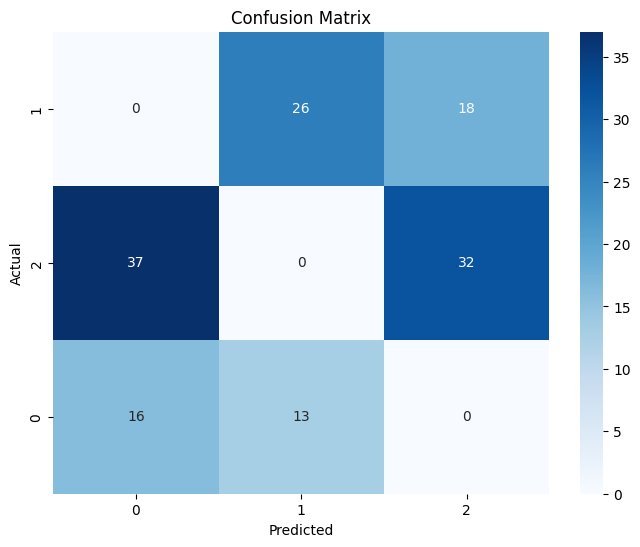

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_df.pred.unique(), yticklabels=val_df.label.unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Inference

In [ ]:
test_df.head()

,Unnamed: 0.1,Unnamed: 0,comment_url,comment_createdAt,comment_id,comment_viewCount,comment_lang,comment_author_createdAt,comment_location,comment_text,...,post_followers,post_verified,post_text,isActor_self__decalred__location__El_Salvador,post_processed_text,actor_affiliation,llama3_output,llama3_reason,manual_labeling,label
0,581,3822,https://x.com/Nutrichica_Lu/status/11239911269...,1.556815e+09,1.123990e+18,NaN,es,16/03/2019,NaN,@easegura Yo ni tiempo tenía jaja a penas y po...,...,45379.0,False,Yo estudié en la UES y les puedo asegurar que ...,True,yo estudié en la ues y les puedo asegurar que ...,"['Media', 'Academia']",0.0,"The tweet is neutral, presenting a factual sta...",0,1
1,743,4621,https://x.com/mysthea/status/1785357765239558346,1.714497e+09,1.785360e+18,8.0,es,09/05/2009,NaN,@suecallejas Y porque la misma asamblea??? Por...,...,132956.0,True,Aprobamos reformar el inciso 2do del artículo ...,True,aprobamos reformar el inciso 2do del artículo ...,NaN,0.0,The tweet is neutral as it asks a question abo...,0,1
2,1239,8072,https://x.com/429bus/status/1377076338230759424,1.617156e+09,1.377080e+18,NaN,es,27/09/2013,"Los Angeles, CA",@FranAlabi Primera dosis de Noderna en Houston...,...,410702.0,True,Más de 30 horas de que me aplicaron la vacuna ...,True,más de 30 horas de que me aplicaron la vacuna ...,Government,0.0,The tweet states a fact about receiving the fi...,0,1
3,1146,7322,https://x.com/DaysiShakespea1/status/176155075...,1.708821e+09,1.761550e+18,67.0,es,31/03/2020,NaN,@MarceloLarin1 la Alexia solo esta ahi para ob...,...,64221.0,True,Hasta hoy la mujer más coherente que he visto ...,False,hasta hoy la mujer más coherente que he visto ...,Media,-1.0,The tweet expresses a negative sentiment towar...,-1,0
4,506,3228,https://x.com/donald_derg/status/1755302542790...,1.707332e+09,1.755300e+18,2516.0,es,06/07/2010,NaN,@easegura Parece que el pasaporte de Sliptone ...,...,45378.0,False,"Una vez más, un líder padillero que ya había s...",True,una vez más un líder padillero que ya había si...,"['Media', 'Academia']",0.0,The tweet presents a factual statement about t...,-1,0


In [ ]:
encoded_data_test = tokenizer.batch_encode_plus(
    test_df.post_processed_text.values,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test_df.label.values)



dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

dataloader_test = DataLoader(dataset_test,
                                   sampler=SequentialSampler(dataset_test),
                                   batch_size=config.batch_size)


In [ ]:
model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(config.device)

model.load_state_dict(torch.load(f'./_BERT_epoch_3.model', map_location=torch.device('cpu')))

_, predictions_test, true_vals_test = evaluate(dataloader_test)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import classification_report

preds_flat_test = np.argmax(predictions_test, axis=1).flatten()
print(classification_report(preds_flat_test, true_vals_test))

              precision    recall  f1-score   support

           0       0.61      0.56      0.59       216
           1       0.22      0.38      0.28        94
           2       0.71      0.51      0.59       190

    accuracy                           0.51       500
   macro avg       0.51      0.49      0.49       500
weighted avg       0.57      0.51      0.53       500



In [ ]:
pred_final = []

for i, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    predictions = []

    review = row["post_processed_text"]
    encoded_data_test_single = tokenizer.batch_encode_plus(
    [review],
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']


    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_final.append(np.argmax(predictions, axis=1).flatten()[0])

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
# add pred into test
test_df["pred"] = pred_final

In [ ]:
#  Add control column for easier wrong and right predictions
control = test_df.pred.values == test_df.label.values
test_df["control"] = control

In [ ]:
# filtering false predictions
test_df = test_df[test_df.control == False]

In [ ]:
test_df["pred_name"] = test_df.pred.apply(lambda x: label2name.get(x))

In [ ]:
test_df.head()

,Unnamed: 0.1,Unnamed: 0,comment_url,comment_createdAt,comment_id,comment_viewCount,comment_lang,comment_author_createdAt,comment_location,comment_text,...,post_text,isActor_self__decalred__location__El_Salvador,post_processed_text,actor_affiliation,llama3_output,llama3_reason,manual_labeling,label,pred,control
1,743,4621,https://x.com/mysthea/status/1785357765239558346,1.714497e+09,1.785360e+18,8.0,es,09/05/2009,NaN,@suecallejas Y porque la misma asamblea??? Por...,...,Aprobamos reformar el inciso 2do del artículo ...,True,aprobamos reformar el inciso 2do del artículo ...,NaN,0.0,The tweet is neutral as it asks a question abo...,0,1,0,False
4,506,3228,https://x.com/donald_derg/status/1755302542790...,1.707332e+09,1.755300e+18,2516.0,es,06/07/2010,NaN,@easegura Parece que el pasaporte de Sliptone ...,...,"Una vez más, un líder padillero que ya había s...",True,una vez más un líder padillero que ya había si...,"['Media', 'Academia']",0.0,The tweet presents a factual statement about t...,-1,0,1,False
5,437,2726,https://x.com/Guerrero8917/status/147991717885...,1.641675e+09,1.479920e+18,NaN,es,13/03/2019,NaN,@ChristianDiffer Estaría muy interesante el de...,...,Máx Keiser ha retado a un debate de economía y...,True,máx keiser ha retado a un debate de economía y...,Media,0.0,"The tweet presents a neutral sentiment, asking...",0,1,0,False
6,95,416,https://x.com/chamaguaJR/status/17730416343111...,1.711561e+09,1.773040e+18,29017.0,es,08/05/2020,"Sonsonate, El Salvador","@nayibbukele El Estado Salvadoreño, es diferen...",...,Nuestra Marina Nacional incautó una lancha a 4...,True,nuestra marina nacional incautó una lancha a 4...,Government,0.0,The tweet presents a factual statement about t...,0,1,2,False
7,550,3601,https://x.com/_OswaldoGF/status/14422971255351...,1.632705e+09,1.442300e+18,NaN,es,17/05/2011,El Salvador,@easegura @mxgxw_gamma No quiero eso para mi y...,...,La captura de cualquier ciudadano será ordenad...,True,la captura de cualquier ciudadano será ordenad...,"['Media', 'Academia']",-1.0,The tweet expresses a negative sentiment as it...,-1,0,1,False


In [ ]:
from sklearn.metrics import confusion_matrix

# We create a confusion matrix to better observe the classes that the model confuses.
pred_name_values = test_df.pred.values
label_values = test_df.label.values
confmat = confusion_matrix(label_values, pred_name_values, labels=np.unique(label_values))

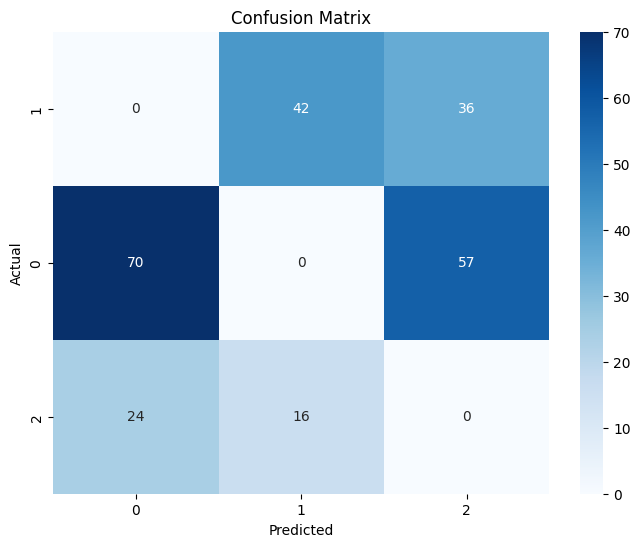

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_df.pred.unique(), yticklabels=test_df.label.unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
confmat

array([[0, 0, 0],
       [2, 0, 0],
       [1, 0, 0]])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

import os
os.makedirs('/content/drive/MyDrive/Omdena/Irex/', exist_ok=True)

# Specify the path to save the file in your Google Drive
save_path = '/content/drive/MyDrive/Omdena/Irex/params_Beto_v1.json'



# Save the file to Google Drive
with open(save_path, 'w') as f:
    json.dump(params, f, ensure_ascii=False, indent=4)

In [ ]:
# Define the path to the folder where you want to save the model
model_save_path = '/content/drive/MyDrive/Omdena/Irex/'

# Save the model to the specified folder
torch.save(model.state_dict(), model_save_path + f'_BERT_epoch_3.model_v1')